# 导入依赖库

In [284]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from utils import get_data_dict, get_ret_mat, compute_ic, compute_ir
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor


# 配置参数

In [285]:
TRAIN_START = '2025-02-01'          # 训练集起始日期
TRAIN_END = '2025-04-30'            # 训练集起始日期
VALID_START = '2025-05-01'          # 验证集起始日期
VALID_END = '2025-05-31'            # 验证集起始日期
IR_THRESHOLD = 0.2                  # IR 阈值
PCA_VARIANCE_THRESHOLD = 0.99        # PCA 方差解释比例阈值
LASSO_CV_FOLDS = 5                  # LassoCV 交叉验证折数
FACTOR_DIR = 'data/factor'          # 因子文件目录


# 因子检验

In [286]:
# 遍历因子目录，选取训练集期间 IR > 阈值的因子
selected_factors = []  # 存储因子文件名
factor_ir = {} 
factor_df = {}
for fname in os.listdir(FACTOR_DIR):
    df = pd.read_csv(os.path.join(FACTOR_DIR, fname), index_col=0, parse_dates=True)
    factor_name = fname[:-4]
    # 假设最后一列为当日 IC，训练期间 IR=mean(IC)/std(IC)
    train_df = df.loc[TRAIN_START:TRAIN_END]
    ic_series = train_df.iloc[:, -1]
    ir = compute_ir(ic_series)
    factor_ir[factor_name] = ir
    if abs(ir) > IR_THRESHOLD:
        selected_factors.append(factor_name)
        factor_df[factor_name] = df.iloc[:, :-1]
selected_factors = sorted(selected_factors)
print(selected_factors)
# print(factor_ir)


['ma_spread_60_10', 'ma_spread_60_3', 'ma_spread_60_5', 'macd', 'momentum_3', 'momentum_40', 'momentum_60', 'obv_120', 'obv_5', 'rsi_42', 'rsi_63', 'turnover_10', 'turnover_120', 'turnover_15', 'turnover_20', 'turnover_3', 'turnover_40', 'turnover_5', 'turnover_60', 'volume_pct_10', 'volume_pct_15', 'volume_pct_20']


# 因子去重

In [287]:
# 将每个因子 DataFrame 转为 (date, code) MultiIndex Sereis
stacked_list = []
for name, df in factor_df.items():
    # df: 行=date, 列=code
    df.columns = df.columns.astype(str)
    s = df.stack()
    s.name = name
    stacked_list.append(s)
# 合并所有因子 Series，axis=1，即得到 MultiIndex index=(date, code)
factors_concat = pd.concat(stacked_list, axis=1).sort_index()


In [288]:
# 提取训练期数据并填充缺失值
train_data = factors_concat.loc[TRAIN_START:TRAIN_END]
valid_data = factors_concat.loc[VALID_START:VALID_END]

# 先做标准化：每列减均值、除以标准差
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
valid_data_scaled = scaler.transform(valid_data)

# 获取 PCA 降维的维数
pre_pca = PCA()
pre_pca.fit(train_data_scaled)
cum_var = np.cumsum(pre_pca.explained_variance_ratio_)
n_components = np.searchsorted(cum_var, PCA_VARIANCE_THRESHOLD) + 1
print(n_components)


14


In [289]:
# PCA 降维
pca = PCA(n_components=n_components)
X_train = pca.fit_transform(train_data_scaled)
X_valid = pca.transform(valid_data_scaled)

# 再标准化
rescaler = StandardScaler()
X_train = rescaler.fit_transform(X_train)
X_valid = rescaler.transform(X_valid)


In [290]:
# 数据集
data_dict = get_data_dict(start=TRAIN_START) 
ret_mat = get_ret_mat(data_dict)
y_train = ret_mat.stack().reindex(train_data.index).values * 1e4
y_valid = ret_mat.stack().reindex(valid_data.index).values * 1e4


In [291]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(3120, 14)
(3120,)
(988, 14)
(988,)


# 训练

In [292]:
mlp = MLPRegressor(
    hidden_layer_sizes=(32, 16, 8),
    activation='relu',
    alpha=3e-5,
    learning_rate_init=1e-4,
    max_iter=1000,
    random_state=42
)
mlp.fit(X_train, y_train)
train_pred = mlp.predict(X_train)


/home/chenkx/anaconda3/envs/24/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [293]:
pred_mat_train = pd.Series(train_pred, index=train_data.index).unstack(level=1)
ic_train = compute_ic(pred_mat_train, ret_mat)
print(f'train ic mean: {ic_train.mean()}')
print(f'train ir: {compute_ir(ic_train)}')


train ic mean: 0.33048718693866325
train ir: 1.733475836042132


# 验证

In [294]:
valid_pred = mlp.predict(X_valid)


In [295]:
pred_mat_valid = pd.Series(valid_pred, index=valid_data.index).unstack(level=1)
ic_valid = compute_ic(pred_mat_valid, ret_mat)
print(f'valid ic mean: {ic_valid.mean()}')
print(f'valid ir: {compute_ir(ic_valid)}')


valid ic mean: 0.16377981721221238
valid ir: 0.7809497032656584


# 可视化

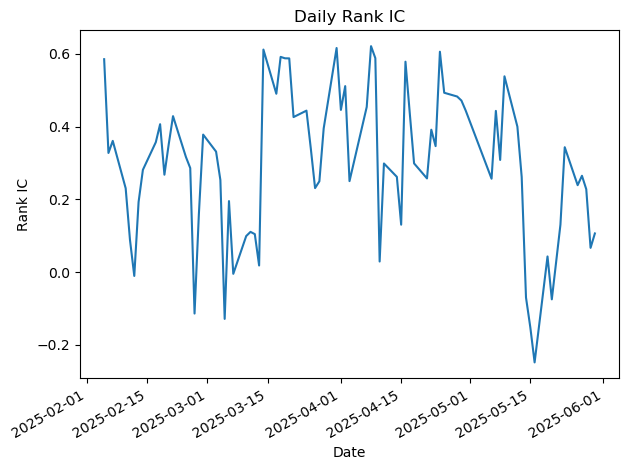

In [296]:
# 可视化
plt.figure()
ic = pd.concat([ic_train, ic_valid])
ic.plot()
plt.title('Daily Rank IC')
plt.xlabel('Date')
plt.ylabel('Rank IC')
plt.tight_layout()
plt.show()


# 存储得分

In [297]:
pred_mat = pd.concat([pred_mat_train, pred_mat_valid])
pred_mat.to_csv('data/score.csv')
